In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

pd.options.display.max_columns = None

In [34]:
# import data week

week_data = pd.read_csv("../raw_data/1_week_RAW.csv")

In [35]:
week_data.head()

,datetime,x_D,y_D,z_D,x_ND,y_ND,z_ND
0,2017-05-04 00:00:00.000000,-0.949,0.035,0.273,-0.957,0.008,0.277
1,2017-05-04 00:00:00.012500,-0.953,0.027,0.273,-0.957,0.000,0.277
2,2017-05-04 00:00:00.025000,-0.953,0.027,0.266,-0.961,0.000,0.270
3,2017-05-04 00:00:00.037500,-0.949,0.023,0.266,-0.957,0.000,0.273
4,2017-05-04 00:00:00.050000,-0.949,0.023,0.270,-0.957,-0.004,0.273


In [36]:
week_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41472000 entries, 0 to 41471999
Data columns (total 7 columns):
 #   Column    Dtype  
---  ------    -----  
 0   datetime  object 
 1   x_D       float64
 2   y_D       float64
 3   z_D       float64
 4   x_ND      float64
 5   y_ND      float64
 6   z_ND      float64
dtypes: float64(6), object(1)
memory usage: 2.2+ GB


We transform the *datetime* column from object to datetime so that we can use pandas functions.

In [37]:
week_data['datetime'] = pd.to_datetime(week_data['datetime'], format='%Y-%m-%d %H:%M:%S.%f')

In [38]:
week_data["datetime"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 41472000 entries, 0 to 41471999
Series name: datetime
Non-Null Count     Dtype         
--------------     -----         
41472000 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 316.4 MB


We compute the **magnitude** for both the dominant and non dominant hand.

In [39]:
week_data['magnitude_D'] = np.sqrt(week_data['x_D']**2 + week_data['y_D']**2 + week_data['z_D']**2)
week_data['magnitude_ND'] = np.sqrt(week_data['x_ND']**2 + week_data['y_ND']**2 + week_data['z_ND']**2)

We compute the **asimettry index** using this formula:

$$ \frac{\text{magnitude}_\text{D} - \text{magnitude}_{\text{ND}}}{\text{magnitude}_\text{D} + \text{magnitude}_{\text{ND}}} \cdot 100$$

In [40]:
week_data["AI"]=(((week_data['magnitude_D'] - week_data['magnitude_ND']) / (week_data['magnitude_D'] + week_data['magnitude_ND'])) * 100).fillna(0)

We split *datetime* column in three new columns: *year*, *month*, *day*.

In [41]:
week_data['year'] = week_data['datetime'].dt.year
week_data['month'] = week_data['datetime'].dt.month
week_data['day'] = week_data['datetime'].dt.day



We sort the columns.

In [42]:
new_order=['datetime', 'year', 'month', 'day', 'AI', 'magnitude_D', 'magnitude_ND', 'x_D', 'y_D', 'z_D', 'x_ND', 'y_ND', 'z_ND']

week_data=week_data[new_order]

In [43]:
week_data.head()

,datetime,year,month,day,AI,magnitude_D,magnitude_ND,x_D,y_D,z_D,x_ND,y_ND,z_ND
0,2017-05-04 00:00:00.000000,2017,5,4,-0.413593,0.988107,0.996314,-0.949,0.035,0.273,-0.957,0.008,0.277
1,2017-05-04 00:00:00.012500,2017,5,4,-0.230537,0.991699,0.996282,-0.953,0.027,0.273,-0.957,0.000,0.277
2,2017-05-04 00:00:00.025000,2017,5,4,-0.423237,0.989795,0.998209,-0.953,0.027,0.266,-0.961,0.000,0.270
3,2017-05-04 00:00:00.037500,2017,5,4,-0.471201,0.985843,0.995177,-0.949,0.023,0.266,-0.957,0.000,0.273
4,2017-05-04 00:00:00.050000,2017,5,4,-0.416516,0.986930,0.995185,-0.949,0.023,0.270,-0.957,-0.004,0.273


We compute the median of the asimmetry index for the overall dataframe.

In [44]:
median=week_data['AI'].median()

print(median)

-0.020795431128620073


Now we also compute the median of the asimmetry index for each day. In order to define our semaphore index we decide to use the median computed for each day instead of the overall median.

In [48]:
week_data_by_day=week_data.groupby(['year', 'month', 'day']).agg({
    'AI' : 'median'
}).reset_index()

week_data_by_day

,year,month,day,AI
0,2017,5,4,1.530858
1,2017,5,5,-0.401845
2,2017,5,6,-0.019327
3,2017,5,7,-0.137668
4,2017,5,8,0.286038
5,2017,5,9,-0.267647


We display the **box plot** in order to search for outliers. In the days in which we find an outlier we set the red light on the semaphore. 

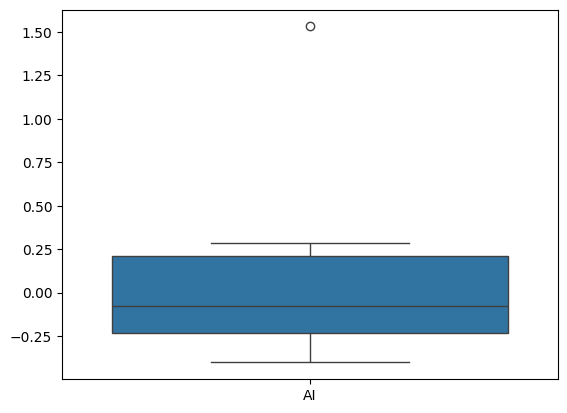

In [47]:
import seaborn as sns

columns_of_interest = ['AI']
data_to_plot = week_data_by_day[columns_of_interest]

# Crea un box plot
ax=sns.boxplot(data=data_to_plot, whis=1.5)